In [1]:
import torch

# Limit to fraction of total GPU memory
torch.cuda.set_per_process_memory_fraction(0.5, device=0)

## Small processed data

### Load data for prediction

In [2]:
%load_ext autoreload
%autoreload 2
from alphagenome_pytorch import SpliceDataset

# Path to test data
test_data_dir = '/home/elek/sds/sd17d003/Anamaria/splicevo/data_new/splits_adult_10kb/mouse_human/test/'

target_length = 10240
max_donor_sites = 20
max_acceptor_sites = 20

species_mapping = {
    'human': 0,
    'mouse': 1
}

test_dataset = SpliceDataset(
    data_dir=test_data_dir,
    target_length=target_length,
    max_donor_sites=max_donor_sites,
    max_acceptor_sites=max_acceptor_sites,
    species_mapping=species_mapping
)

2026-02-15 10:22:05.917709: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-15 10:22:05.958914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded dataset from /home/elek/sds/sd17d003/Anamaria/splicevo/data_new/splits_adult_10kb/mouse_human/test/


In [3]:
next(iter(test_dataset))

{'dna': tensor([ 3,  0,  0,  ..., -1, -1, -1]),
 'organism_index': tensor(0),
 'splice_donor_idx': tensor([1889, 3938, 5825, 5825, 5825, 5825, 5825, 5825, 5825, 5825, 5825, 5825,
         5825, 5825, 5825, 5825, 5825, 5825, 5825, 5825]),
 'splice_acceptor_idx': tensor([2038, 4669, 5912, 5912, 5912, 5912, 5912, 5912, 5912, 5912, 5912, 5912,
         5912, 5912, 5912, 5912, 5912, 5912, 5912, 5912]),
 'num_donors': tensor(3),
 'num_acceptors': tensor(3),
 'splice_labels': tensor([4, 4, 4,  ..., 4, 4, 4]),
 'splice_usage_target': tensor([[0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'conditions_mask': tensor([ 0,  4, 10, 11, 13, 16, 17, 21, 22, 23, 25, 26, 27, 32, 36, 37])}

In [4]:
import os
import pandas as pd

meta_csv_fn = os.path.join(test_data_dir, 'metadata.csv')
metadata_csv = pd.read_csv(meta_csv_fn)
metadata_csv

,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id
0,11,hum.10123,human_GRCh37,10,7,-,26592773,26582773,0
1,11,hum.10118,human_GRCh37,0,1,+,26363869,26353869,0
2,11,hum.10118,human_GRCh37,1,1,+,26463869,26453869,0
3,11,hum.10118,human_GRCh37,1,1,+,26473869,26463869,0
4,11,hum.10118,human_GRCh37,1,1,+,26493869,26483869,0
...,...,...,...,...,...,...,...,...,...
9918,4,mou.33628,mouse_GRCm38,414,442,+,156246071,156236071,1
9919,4,mou.33628,mouse_GRCm38,59,33,+,156256071,156246071,1
9920,4,mou.33620,mouse_GRCm38,1894,1812,-,156176058,156166058,1
9921,4,mou.33620,mouse_GRCm38,791,819,-,156186058,156176058,1


In [5]:
import json

meta_fn = os.path.join(test_data_dir, 'metadata.json')
with open(meta_fn) as f:
    metadata = json.load(f)

species_conds = metadata['species_condition_mapping']

for org, cond in species_conds.items():
    print(f"Condition for {org}:")
    print([metadata['usage_conditions'][cond_idx] for cond_idx in cond])

Condition for human:
['Brain_10', 'Brain_14', 'Cerebellum_15', 'Heart_10', 'Heart_12', 'Kidney_10', 'Kidney_11', 'Liver_10', 'Liver_11', 'Liver_12', 'Liver_14', 'Liver_15', 'Ovary_10', 'Testis_10', 'Testis_14', 'Testis_15']
Condition for mouse:
['Brain_10', 'Brain_11', 'Brain_12', 'Brain_13', 'Brain_14', 'Cerebellum_10', 'Cerebellum_11', 'Cerebellum_12', 'Cerebellum_13', 'Cerebellum_14', 'Heart_10', 'Heart_11', 'Heart_12', 'Heart_13', 'Heart_14', 'Kidney_10', 'Kidney_11', 'Kidney_12', 'Kidney_13', 'Kidney_14', 'Liver_10', 'Liver_11', 'Liver_12', 'Liver_13', 'Ovary_10', 'Ovary_11', 'Ovary_12', 'Ovary_13', 'Ovary_14', 'Testis_10', 'Testis_11', 'Testis_12', 'Testis_13', 'Testis_14']


### Check that the inputs are correctly encoded

The genomic coordinates of the first sequence in the test set.

In [7]:
import os
import pandas as pd
meta_csv_fn = os.path.join(test_data_dir, "metadata.csv")
meta_csv = pd.read_csv(meta_csv_fn)

i=0
chr = str(meta_csv.loc[i, 'chromosome'])
start = int(meta_csv.loc[i, 'window_start'])
end = int(meta_csv.loc[i, 'window_end'])
strand = str(meta_csv.loc[i, 'strand'])
coord = f"{chr}:{start}-{end}"
print(coord, strand)

11:26582773-26592773 -


Extracting the corresponding fasta and gtf records for this region.

```bash
fasta_fn="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/fasta/Homo_sapiens.fa.gz"
gtf_fn="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz"
coord="11:26582773-26592773"

# Sort and index if needed
zcat /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz \
  | sort -k1,1 -k4,4n \
  | bgzip > /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz
tabix -p gff /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz
gtf_fn=/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz

# Extract fasta sequence
samtools faidx $fasta_fn $coord > region.fa

# Extract gtf records
tabix $gtf_fn $coord > region.gtf
```

Check that the extracted fasta region corresponds correctly to the ohe DNA in the dataset.  
Compare to:
```bash
head region.fa -n 2
```

In [8]:
dna_window = test_dataset[i]['dna']
print(dna_window[0:60])

def ohe(dna_ohe):
    """[0, 1, 2, 3] -> [A, C, G, T]"""
    return ''.join(['ACGT'[i] for i in dna_ohe])
def rev(dna_seq):
    """Reverse complement a DNA sequence"""
    complement = str.maketrans('ACGT', 'TGCA')
    return dna_seq.translate(complement)

dna_seq = ohe(dna_window)
if strand == '+':
    print(dna_seq[0:60])
if strand == '-':
    print(rev(dna_seq[0:60]))

tensor([3, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 3, 0, 1, 3, 2,
        3, 3, 3, 1, 0, 1, 0, 2, 3, 2, 0, 3, 0, 1, 3, 1, 3, 2, 0, 0, 0, 2, 0, 3,
        3, 1, 0, 3, 2, 3, 3, 1, 0, 2, 2, 1])
ATTTTTTCATTGTTTTATTATGACAAAGTGTCACTATGAGACTTTCTAAGTACAAGTCCG


Check that splice site coordinates are correct.  
Compare to:
```bash
head region.gtf
```

In [9]:
splice_sites = test_dataset[i]['splice_labels']

splice_donor_idx = test_dataset[i]['splice_donor_idx'].unique().numpy()
splice_acceptor_idx = test_dataset[i]['splice_acceptor_idx'].unique().numpy()

splice_donor_encode = splice_sites[splice_donor_idx].numpy()
splice_acceptor_encode = splice_sites[splice_acceptor_idx].numpy()

splice_donor_count = len(splice_sites[splice_sites == splice_donor_encode[0]])
splice_acceptor_count = len(splice_sites[splice_sites == splice_acceptor_encode[0]])

# Check that encoding at splice sites corresponds to idx 
print(f"\nDonors: {splice_donor_idx}")
print(f"Genomic coordinates: {[int(start + idx) for idx in splice_donor_idx]}")
print(f"Donors on {strand} strand encoded as: {splice_donor_encode}")
print(f"There are {splice_donor_count} donor sites in this sequence.")

print(f"\nAcceptors: {splice_acceptor_idx}")
print(f"Genomic coordinates: {[int(start + idx) for idx in splice_acceptor_idx]}")
print(f"Acceptors on {strand} strand encoded as: {splice_acceptor_encode}")
print(f"There are {splice_acceptor_count} acceptor sites in this sequence.")


Donors: [1889 3938 5825]
Genomic coordinates: [26584662, 26586711, 26588598]
Donors on - strand encoded as: [2 2 2]
There are 3 donor sites in this sequence.

Acceptors: [2038 4669 5912]
Genomic coordinates: [26584811, 26587442, 26588685]
Acceptors on - strand encoded as: [3 3 3]
There are 3 acceptor sites in this sequence.


### Subset _n_ sequences for prediction

First _n_ sequences from the test set.

In [10]:
import torch
import numpy as np

np.random.seed(1950)

n_per_species = 64
n = n_per_species * len(species_mapping)
rand_indx = []
for species in species_mapping.keys():
    species_id = metadata['species_mapping'][species]
    species_idx = metadata_csv[metadata_csv['species_id'] == species_id].index.tolist()
    print(f"{len(species_idx)} samples available for {species}")
    rand_indx.extend(np.random.choice(species_idx, n_per_species, replace=False))

organism_index = []
for i in rand_indx:
    organism_index.append(test_dataset[i]['organism_index'])

organism_index = torch.tensor(organism_index)
print(organism_index.shape)
organism_index

1853 samples available for human
8070 samples available for mouse


torch.Size([128])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

Organism that the first _n_ sequences belong to.

In [11]:
dna = []
for i in rand_indx:
    dna.append(test_dataset[i]['dna'])
dna = torch.stack(dna)
print(dna.shape)
dna

torch.Size([128, 10240])


tensor([[ 2,  2,  2,  ..., -1, -1, -1],
        [ 1,  0,  3,  ..., -1, -1, -1],
        [ 3,  2,  3,  ..., -1, -1, -1],
        ...,
        [ 3,  2,  3,  ..., -1, -1, -1],
        [ 2,  2,  3,  ..., -1, -1, -1],
        [ 1,  3,  0,  ..., -1, -1, -1]])

Splice labels

In [12]:
splice_labels = []
for i in rand_indx:
    splice_labels.append(test_dataset[i]['splice_labels'])
splice_labels = torch.stack(splice_labels)
print(splice_labels.shape)
splice_labels

torch.Size([128, 10240])


tensor([[4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        ...,
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4]])

Splice usage

In [13]:
splice_usage = []
for i in rand_indx:
    splice_usage.append(test_dataset[i]['splice_usage_target'])
splice_usage = torch.stack(splice_usage)
print(splice_usage.shape)
splice_usage

torch.Size([128, 10240, 38])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

 ## Predictions

Load model for predictions

### Load pretrained model

In [6]:
import torch
from alphagenome_pytorch import AlphaGenome
from pathlib import Path

def load_pretrained_model(cache_dir='../outputs/checkpoints/pretrained', num_organisms=2):
    """
    Load the pretrained AlphaGenome model with caching.
    
    First time: Downloads and converts JAX model (~5 minutes) and caches it
    Subsequent times: Loads from cache (under 1 minute)
    
    Args:
        cache_dir: Directory to store cached model
        num_organisms: Number of organisms (default: 2 for human and mouse)
    
    Returns:
        model: AlphaGenome model in eval mode
    """
    # Path to cache the converted model
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(exist_ok=True, parents=True)
    cached_model_path = cache_dir / 'pretrained_model.pt'
    
    model = AlphaGenome(num_organisms=num_organisms)
    model.add_reference_heads("human")
    model.add_reference_heads('mouse')
    
    # Load from cache if available, otherwise download and cache
    if cached_model_path.exists():
        print(f"Loading pretrained model from cache: {cached_model_path}")
        checkpoint = torch.load(cached_model_path, map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded from cache (fast!)")
    else:
        print("Downloading and converting JAX model (this will take ~5 minutes)...")
        model.load_from_official_jax_model("all_folds")
        print("Saving to cache for future use...")
        torch.save({'model_state_dict': model.state_dict()}, cached_model_path)
        print(f"Model cached to {cached_model_path}")
    
    model.eval()
    return model

In [7]:
use_pretrained_model = True

if use_pretrained_model:
    model = load_pretrained_model()

Loading pretrained model from cache: ../outputs/checkpoints/pretrained/pretrained_model.pt
Model loaded from cache (fast!)


### Load fine-tuned model

In [30]:
import os
import yaml
import torch
from alphagenome_pytorch import AlphaGenome, AlphaGenomeConfig

use_finetuned_model = True

if use_finetuned_model:

    # Load config
    config_file = '../configs/splice_finetune_adult_10kb.yaml'
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)

    # Get model architecture parameters (matching training)
    default_cfg = AlphaGenomeConfig()
    model_cfg = config.get('model', {})
    dims = tuple(model_cfg.get('dims', default_cfg.dims))
    basepairs = model_cfg.get('basepairs', default_cfg.basepairs)
    dna_embed_width = model_cfg.get('dna_embed_width', default_cfg.dna_embed_width)
    num_organisms = model_cfg.get('num_organisms', default_cfg.num_organisms)
    transformer_kwargs = model_cfg.get('transformer_kwargs', default_cfg.transformer_kwargs)
    heads_cfg = model_cfg.get('heads_cfg')

    # Create model with same architecture as training
    model = AlphaGenome(dims, basepairs, dna_embed_width, num_organisms, transformer_kwargs)

    # Add heads with same config as training
    for organism, head_cfg in heads_cfg.items():
        model.add_heads(organism=organism, **head_cfg)

    # Load the checkpoint
    output_dir = config.get('output_dir', './outputs')
    model_name = config.get('model_name', 'alphagenome_finetuned')
    checkpoint_path = os.path.join(output_dir, f'{model_name}.pt')
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Set to eval mode
    model.eval()

    print(f"Model loaded from {checkpoint_path}")
    print(f"Trained for {checkpoint['epoch']} epochs")

/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/torch/nn/modules/linear.py:124: UserWarning: Initializing zero-element tensors is a no-op
  init.kaiming_uniform_(self.weight, a=math.sqrt(5))


Model loaded from /home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/adult_mouse_human_10kb/finetune_splice_heads.pt
Trained for 21 epochs


### Predictions on the subset of data

Get track predictions.

Pretrained model is supposed to get splice logits right since these are the same predictions as the model was trained on. Splice usage is not expected to be accurate since model was not trained on and doesn't predict these samples.

Fine-tuned model is supposed to get both splice logits and splice usage right since it was trained on these samples.

In [ ]:
predictions = model.inference(
    dna,
    organism_index=organism_index,
    requested_heads=['splice_sites_classification', 'splice_sites_usage']
)

In [ ]:
for org in predictions:
    print(f"\nPredictions for {org}:")
    for head in predictions[org]:
        print(f"  {head}: shape {predictions[org][head].shape}")

### Prediction on a random batch

In [8]:
import numpy as np
from alphagenome_pytorch.samplers import SpeciesGroupedSampler
from torch.utils.data import DataLoader

# Create sampler
test_sampler = SpeciesGroupedSampler(test_dataset, batch_size=128, shuffle=False)

# Create dataloader for entire test set
test_loader_full = DataLoader(
    test_dataset, 
    batch_sampler=test_sampler, 
    num_workers=4
)

# Select a random batch index
np.random.seed(1950)
rnd_batch_idx = np.random.randint(0, len(test_loader_full))
rnd_batch_idx = 6

# Predict on one batch
for batch_idx, batch in enumerate(test_loader_full):
    if batch_idx == rnd_batch_idx:
        print(f"Predicting on batch {batch_idx} (randomly selected)")
        print("Batch keys:", batch.keys())
        print("DNA shape:", batch['dna'].shape)
        print("Organism index shape:", batch['organism_index'].shape)
        print("Splice labels shape:", batch['splice_labels'].shape)
        print("Splice usage target shape:", batch['splice_usage_target'].shape)

        with torch.no_grad():

            # Data to predict for
            dna = batch['dna']
            organism_index = batch['organism_index']

            # True splice labels
            splice_labels = batch['splice_labels']

            # True usage
            splice_usage = batch['splice_usage_target']

            # Generate predictions
            predictions = model.inference(
                dna, 
                organism_index=organism_index,
                requested_heads=['splice_sites_classification', 'splice_sites_usage']
            )

            # Process each sample in batch
            for i in range(dna.shape[0]):
                organism = organism_index[i].item()
                organism_name = list(species_mapping.keys())[organism]

        break  # Just check one batch
    else:
        continue

Predicting on batch 6 (randomly selected)
Batch keys: dict_keys(['dna', 'organism_index', 'splice_donor_idx', 'splice_acceptor_idx', 'num_donors', 'num_acceptors', 'splice_labels', 'splice_usage_target', 'conditions_mask'])
DNA shape: torch.Size([128, 10240])
Organism index shape: torch.Size([128])
Splice labels shape: torch.Size([128, 10240])
Splice usage target shape: torch.Size([128, 10240, 38])


### Splice site predictions

In [9]:
splice_logits = {}
for org in predictions:
    splice_logits_org = predictions[org]['splice_sites_classification'][organism_index == species_mapping[org]]
    print(f"{org} splice logits shape: {splice_logits_org.shape}")
    splice_logits[org] = splice_logits_org.detach().cpu()

human splice logits shape: torch.Size([128, 10240, 5])
mouse splice logits shape: torch.Size([0, 10240, 5])


In [10]:
splice_labels_pred = {}
for org in predictions:
    splice_labels_pred_org = splice_logits[org].argmax(dim=-1)
    print(f"{org} splice labels pred shape: {splice_labels_pred_org.shape}")
    splice_labels_pred[org] = splice_labels_pred_org

human splice labels pred shape: torch.Size([128, 10240])
mouse splice labels pred shape: torch.Size([0, 10240])


In [11]:
# Get count of true classes
splice_labels_true = {}
for org in predictions:
    if (organism_index == species_mapping[org]).int().sum() == 0:
        print(f"No samples for {org} in this batch.\n")
        continue
    print(f"True labels for {org}:")
    splice_label_org = splice_labels[organism_index == species_mapping[org]]
    splice_labels_true[org] = splice_label_org
    splice_label_flat = splice_label_org.flatten().numpy()
    for i in range(5):
        count = np.sum(splice_label_flat == i)
        print(f"  Class {i}: {count}")
    # Get count of predicted classes
    print(f"\nPredicted labels for {org}:")
    splice_label_pred_flat = splice_labels_pred[org].flatten().numpy()
    for i in range(5):
        count = np.sum(splice_label_pred_flat == i)
        print(f"  Class {i}: {count}")


True labels for human:
  Class 0: 134
  Class 1: 116
  Class 2: 122
  Class 3: 114
  Class 4: 1310234

Predicted labels for human:
  Class 0: 106
  Class 1: 103
  Class 2: 97
  Class 3: 102
  Class 4: 1310312
No samples for mouse in this batch.



In [12]:
import numpy as np
import pandas as pd

splice_results = {}
splice_results_df = {}
for org in predictions:

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    splice_logits_flat = splice_logits[org].reshape(-1, splice_logits[org].shape[-1])
    splice_labels_flat = splice_labels_true[org].reshape(-1)

    splice_results[org] = {}
    splice_sites_ = np.where(splice_labels_true[org] != 4) # Not not-a-splice-site
    for i in range(len(splice_sites_[0])):
        sample_idx = splice_sites_[0][i]
        position = splice_sites_[1][i]
        splice_labels_ = splice_labels_true[org][sample_idx, position]
        splice_logits_ = splice_logits[org][sample_idx, position, :]
        splice_preds_ = splice_logits_.softmax(dim=-1)
        splice_results[org][i] = {
            'sample_idx': sample_idx,
            'position': position,
            'label': splice_labels_.cpu().numpy(),
            'pred_0': splice_preds_[0].cpu().numpy(),
            'pred_1': splice_preds_[1].cpu().numpy(),
            'pred_2': splice_preds_[2].cpu().numpy(),
            'pred_3': splice_preds_[3].cpu().numpy(),
            'pred_4': splice_preds_[4].cpu().numpy()
        }
    splice_df = pd.DataFrame.from_dict(splice_results[org], orient='index')
    splice_results_df[org] = splice_df


No samples for mouse in this batch.


In [13]:
# Merge dataframes for human and mouse
splice_df = pd.concat(splice_results_df.values(), keys=splice_results_df.keys())
splice_df.reset_index(level=0, inplace=True)
splice_df.rename(columns={'level_0': 'organism'}, inplace=True)
splice_df

,organism,sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4
0,human,0,1547,1,0.00024364618,0.9837383,0.00016221483,2.586919e-05,0.015829908
1,human,0,1654,0,0.99163604,0.0005107073,5.3544863e-05,0.00017645567,0.007623259
2,human,0,2612,1,0.0004601527,0.99316907,8.0625185e-05,6.576959e-05,0.0062242807
3,human,0,2656,0,0.99389476,0.00061546906,4.024899e-05,0.00014165537,0.005307699
4,human,0,4179,1,0.00086451764,0.9947179,0.00012757917,4.177832e-05,0.0042481767
...,...,...,...,...,...,...,...,...,...
481,human,125,4507,2,0.00023128421,0.00010758115,0.60379803,0.00024114265,0.39562193
482,human,125,4721,3,0.00021182114,0.00018016933,0.00034547903,0.8213328,0.17792976
483,human,126,9989,3,1.2707663e-07,2.0804215e-07,3.1505248e-08,3.4271154e-05,0.9999653
484,human,127,1668,2,0.00019119635,0.00041219287,0.63093245,0.00034983087,0.36811432


Splice logits and true labels

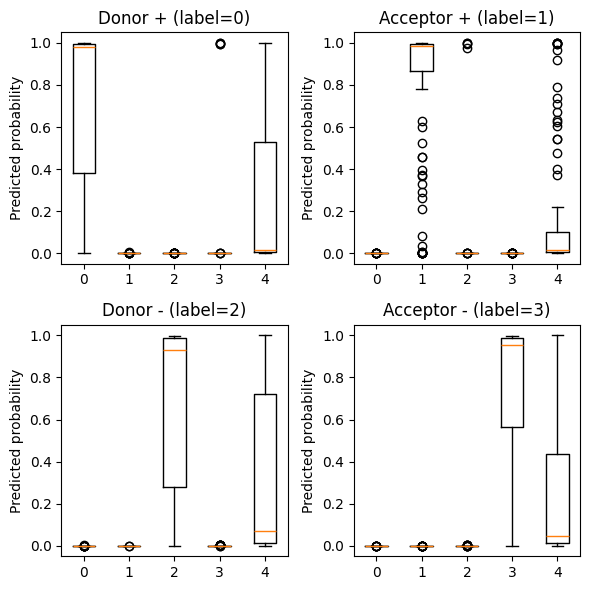

In [14]:
import matplotlib.pyplot as plt

# Plot boxplot of predicted probabilities for each class at true classes
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.title("Donor + (label=0)")
plt.boxplot([splice_df[splice_df['label'] == 0][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.subplot(2, 2, 2)
plt.title("Acceptor + (label=1)")
plt.boxplot([splice_df[splice_df['label'] == 1][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.subplot(2, 2, 3)
plt.title("Donor - (label=2)")
plt.boxplot([splice_df[splice_df['label'] == 2][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.subplot(2, 2, 4)
plt.title("Acceptor - (label=3)")
plt.boxplot([splice_df[splice_df['label'] == 3][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.tight_layout()
plt.show()

/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


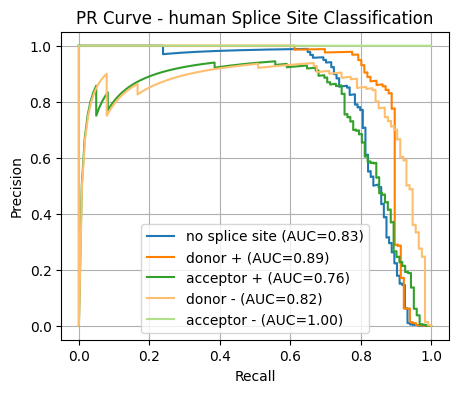

No samples for mouse in this batch.


In [15]:
pr_auc_scores = {}
class_labels = {0: 'no splice site', 1: 'donor +', 2: 'acceptor +', 3: 'donor -', 4: 'acceptor -'}
class_colors = {0: '#1f78b4', 1: '#ff7f00', 2: '#33a02c', 3:'#fdbf6f', 4: '#b2df8a'}

for org in splice_logits.keys():

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    splice_logits_flat = splice_logits[org].reshape(-1, splice_logits[org].shape[-1]).detach().to('cpu').numpy()
    splice_labels_flat = splice_labels_true[org].reshape(-1).detach().to('cpu').numpy()

    from sklearn.metrics import precision_recall_curve, auc

    plt.figure(figsize=(5, 4))

    for i in range(5):
        color = class_colors[i]
        label = class_labels[i]
        
        class_idx = splice_labels_flat == i
        y_true = np.zeros_like(splice_labels_flat)
        y_true[class_idx] = 1
        y_scores = splice_logits_flat[:, i]

        if len(y_true) > 0 and y_true.sum() > 0:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            pr_auc = auc(recall, precision)
            pr_auc_scores[i] = pr_auc
            
            plt.plot(recall, precision, label=f"{label} (AUC={pr_auc:.2f})", color=color)
        else:
            pr_auc_scores[i] = 0.0
            print(f"  Warning: No positive samples for {label}") 

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve - {org} Splice Site Classification")
    plt.legend()
    plt.grid()
    plt.show()

### Splice usage predictions

In [40]:
# Only evaluate splice site positions (labels != 0)
splice_site_mask = splice_labels != 4  # (batch, seq_len)
donor_plus_mask = splice_labels == 0
acceptor_plus_mask = splice_labels == 1
donor_minus_mask = splice_labels == 2
acceptor_minus_mask = splice_labels == 3

if splice_site_mask.any():

    usage_true_bins_ = {}
    usage_pred_ = {}
    usage_true_ = {}

    for org in predictions:
        
        if splice_logits[org].shape[0] == 0:
            print(f"No samples for {org} in this batch.")
            continue

        print(f"\nEvaluating splice usage predictions for {org} at splice site positions:")

        # Predicted and true splice usage
        org_sse_pred = predictions[org]['splice_sites_usage'].sigmoid()
        org_sse_true = splice_usage

        # Select only splice site positions
        usage_true_at_sites = org_sse_true[splice_site_mask, :]
        usage_pred_at_sites = org_sse_pred[splice_site_mask, :]

        # Subset by organism
        usage_true_at_sites = usage_true_at_sites[:,species_conds[org]]
        usage_pred_at_sites = usage_pred_at_sites[:,range(len(species_conds[org]))]

        # Convert to numpy for evaluation
        usage_true_org = usage_true_at_sites.detach().cpu().numpy()
        usage_pred_org = usage_pred_at_sites.detach().cpu().numpy()

        # Remove rows with all zeros in true usage (not used for evaluation)
        non_zero_rows = ~np.all(usage_true_org == 0, axis=1)
        usage_true_org = usage_true_org[non_zero_rows]
        usage_pred_org = usage_pred_org[non_zero_rows]

        # Flatten for plotting
        cols = species_conds[org]  # Get columns corresponding to the condition of the organism
        usage_pred_[org] = usage_pred_org.flatten()
        usage_true_[org] = usage_true_org.flatten()

        # Group true usage in bins: 0 - 0.2 - 0.5 - 0.8 - 1.0
        usage_true_bins = np.zeros_like(usage_true_[org], dtype=int)
        usage_true_bins[usage_true_[org] < 0.2] = 0
        usage_true_bins[(usage_true_[org] >= 0.2) & (usage_true_[org] < 0.5)] = 1
        usage_true_bins[(usage_true_[org] >= 0.5) & (usage_true_[org] < 0.8)] = 2
        usage_true_bins[usage_true_[org] >= 0.8] = 3

        usage_true_bins_[org] = usage_true_bins

        # Count number of values in each bin
        for i in range(4):
            count = np.sum(usage_true_bins == i)
            print(f"True usage bin {i}: {count} values")


No samples for human in this batch.

Evaluating splice usage predictions for mouse at splice site positions:
True usage bin 0: 3408 values
True usage bin 1: 241 values
True usage bin 2: 972 values
True usage bin 3: 7143 values


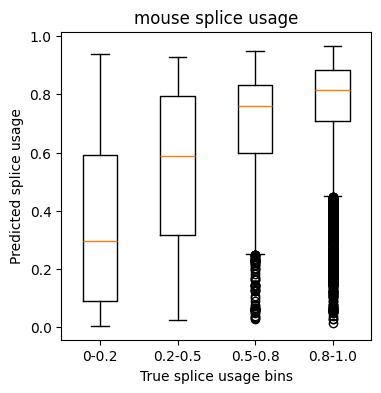

In [41]:
# Plot boxplot of predicted usage for each true usage bin
for org in usage_pred_.keys():

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    plt.figure(figsize=(4, 4))
    plt.title(f"{org} splice usage")
    plt.boxplot([usage_pred_[org][usage_true_bins_[org] == i] for i in range(4)], tick_labels=['0-0.2', '0.2-0.5', '0.5-0.8', '0.8-1.0'])
    plt.ylabel("Predicted splice usage")
    plt.xlabel("True splice usage bins")
    #plt.ylim(0, 1)
    plt.show()

Correlation between true and predicted splice usage for mouse: 0.634


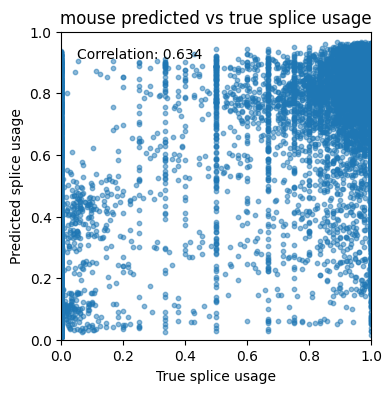

In [42]:
for org in usage_pred_.keys():

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    # Calculate correlation between true and predicted usage at splice sites
    correlation = np.corrcoef(usage_true_[org], usage_pred_[org])[0, 1]
    print(f"Correlation between true and predicted splice usage for {org}: {correlation:.3f}")

    # Plot scatter plot of predicted usage vs true usage
    plt.figure(figsize=(4, 4))
    plt.title(f"{org} predicted vs true splice usage")
    plt.scatter(usage_true_[org], usage_pred_[org], alpha=0.5, s=10)
    plt.xlabel("True splice usage")
    plt.ylabel("Predicted splice usage")
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # Add correlation text
    plt.text(0.05, 0.95, f"Correlation: {correlation:.3f}", transform=plt.gca().transAxes, verticalalignment='top')

    plt.show()

In [ ]:
# Combine in a DataFrame: org, condition_idx, true_sse, pred_sse
data_arrays = {
    'organism': [],
    'sequence_idx': [],
    'position': [],
    'true_usage': [],
    'pred_usage': [],
    'condition_idx': [],
    'condition_name': [],
    'tissue': [],
    'timepoint': []
}

for org in predictions:
    print(f"\nBuilding dataframe for {org}:")
    
    # Get organism-specific mask
    org_mask = organism_index == species_mapping[org]
    
    # Get organism-specific predictions and true values
    org_sse_pred = predictions[org]['splice_sites_usage'].sigmoid()
    org_sse_pred = org_sse_pred[org_mask]
    org_sse_true = splice_usage[org_mask]
    
    # Get splice site positions for this organism
    org_splice_mask = splice_site_mask[org_mask]
    
    # Get sequence and position indices for splice sites
    splice_site_indices = torch.where(org_splice_mask)
    sequence_indices = splice_site_indices[0].cpu().numpy()  # Which sequence (dim 0)
    position_indices = splice_site_indices[1].cpu().numpy()  # Which position (dim 1)
    
    # Select only splice site positions
    usage_true_at_sites = org_sse_true[org_splice_mask, :]
    usage_pred_at_sites = org_sse_pred[org_splice_mask, :]
    
    # Get condition indices for this organism
    org_conds = species_conds[org]
    num_sites = usage_true_at_sites.shape[0]
    num_conds = len(org_conds)
    
    # Convert to numpy once
    true_vals = usage_true_at_sites.cpu().numpy()  # shape: (num_sites, num_total_conditions)
    pred_vals = usage_pred_at_sites.detach().cpu().numpy()  # shape: (num_sites, num_org_conditions)
    
    # Build arrays for this organism
    for cond_idx_pred, cond_idx_true in enumerate(org_conds):
        cond_name = metadata['usage_conditions'][cond_idx_true]
        tissue, timepoint = cond_name.split('_')
        data_arrays['organism'].append(np.full(num_sites, org, dtype=object))
        data_arrays['true_usage'].append(true_vals[:, cond_idx_true])
        data_arrays['pred_usage'].append(pred_vals[:, cond_idx_pred])
        data_arrays['sequence_idx'].append(sequence_indices)
        data_arrays['position'].append(position_indices)
        data_arrays['condition_idx'].append(np.full(num_sites, cond_idx_true, dtype=int))
        data_arrays['condition_name'].append(np.full(num_sites, cond_name, dtype=object))
        data_arrays['tissue'].append(np.full(num_sites, tissue, dtype=object))
        data_arrays['timepoint'].append(np.full(num_sites, timepoint, dtype=object))
    
    print(f"  Added {num_sites * num_conds} rows for {org}")

# Concatenate all arrays at once
all_data_df = pd.DataFrame({
    'organism': np.concatenate(data_arrays['organism']),
    'sequence_idx': np.concatenate(data_arrays['sequence_idx']),
    'position': np.concatenate(data_arrays['position']),
    'true_usage': np.concatenate(data_arrays['true_usage']),
    'pred_usage': np.concatenate(data_arrays['pred_usage']),
    'condition_idx': np.concatenate(data_arrays['condition_idx']),
    'condition_name': np.concatenate(data_arrays['condition_name']),
    'tissue': np.concatenate(data_arrays['tissue']),
    'timepoint': np.concatenate(data_arrays['timepoint'])
})

print(f"\nTotal rows in dataframe: {len(all_data_df)}")

# How many conditions/tissues/timepoints have true_usage > 0 for each site?
site_stats = all_data_df[all_data_df['true_usage'] > 0].groupby(['sequence_idx', 'position']).agg({
    'condition_idx': 'nunique',
    'timepoint': 'nunique',
    'tissue': 'nunique'
}).rename(columns={
    'condition_idx': 'num_conditions',
    'timepoint': 'num_timepoints',
    'tissue': 'num_tissues'
})

# Merge back to the original dataframe
all_data_df = all_data_df.merge(site_stats, on=['sequence_idx', 'position'], how='left').fillna(0)
all_data_df['num_conditions'] = all_data_df['num_conditions'].astype(int)
all_data_df['num_timepoints'] = all_data_df['num_timepoints'].astype(int)
all_data_df['num_tissues'] = all_data_df['num_tissues'].astype(int)

# Only evaluate position with usage data
all_data_df = all_data_df[all_data_df['num_conditions'] > 0]

print(f"\nTotal rows in dataframe: {len(all_data_df)}")

all_data_df

Per-condition splice usage predictions and true values.

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_sse_density(
        all_data_df: pd.DataFrame, 
        group_by: str, 
        output_dir: Path = None,
        log_fn=print
    ):
        """Plot density of predicted vs true SSE values.
        Args:
            all_data_df: DataFrame with SSE data, it should contain columns 'true_usage' and 'pred_usage' along with grouping columns
            group_by: Column name or list of column names to group by
            output_dir: Directory to save output
            log_fn: Logging function
        """
            
        log_fn("Plotting SSE density...")
        
        # Get valid positions where we have both true and predicted SSE
        valid_data = all_data_df.dropna(subset=['true_usage', 'pred_usage'])

        # Get unique combinations of grouping variables
        groups = valid_data.groupby(group_by).size().reset_index(name='count')
        num_groups = len(groups)
        
        # Determine subplot layout
        num_cols = min(3, num_groups)  # Max 3 columns
        num_rows = (num_groups + num_cols - 1) // num_cols
        
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4.8, num_rows * 4), squeeze=False)
        
        for i, (group_idx, group_row) in enumerate(groups.iterrows()):
            # Build filter for this group
            mask = pd.Series([True] * len(valid_data), index=valid_data.index)
            for col in group_by:
                mask &= (valid_data[col] == group_row[col])
            
            condition_data = valid_data[mask]
            
            # Build title from group values
            if len(group_by) == 1:
                title = f"{group_row[group_by[0]]}"
            else:
                title = ", ".join([f"{col}: {group_row[col]}" for col in group_by])
            
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
                    
            # 2D hexbin plot
            hb = ax.hexbin(
                condition_data['true_usage'],
                condition_data['pred_usage'],
                gridsize=30,
                cmap='rocket_r',
                mincnt=1
            )
            plt.colorbar(
                hb,
                ax=ax,
                label='Count',
                pad=0.2
            )
            
            # Add pearson correlation value and number of points to plot
            num_points = len(condition_data)
            if num_points >= 2:
                corr = np.corrcoef(condition_data['true_usage'], condition_data['pred_usage'])[0, 1]
                ax.text(0.05, 0.95, f"r = {corr:.2f}\nn = {num_points}", transform=ax.transAxes, fontsize=10, verticalalignment='top')    
            else:
                ax.text(0.05, 0.95, f"n = {num_points}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
                
            # Top histogram (True SSE)
            ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
            ax_histx.hist(condition_data['true_usage'], bins=30, color='gray', alpha=0.7)
            ax_histx.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
            
            # Right histogram (Pred SSE)
            ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
            ax_histy.hist(condition_data['pred_usage'], bins=30, orientation='horizontal', color='gray', alpha=0.7)
            ax_histy.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
            
            ax.set_xlabel('True Usage', fontsize=10)
            ax.set_ylabel('Predicted Usage', fontsize=10)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_title(title, fontsize=12)
            ax.grid()
        
        # Hide unused subplots
        for i in range(num_groups, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            axs[row, col].set_visible(False)
        
        plt.tight_layout()
        if output_dir is not None:
            density_plot = output_dir / "sse_density.png"
            plt.savefig(density_plot, dpi=150)
            plt.close()
            log_fn(f"Saved density plot to {density_plot}")
        else:
            plt.show()

In [ ]:
%matplotlib inline
plot_sse_density(
    all_data_df,
    group_by=['organism']
)